In [17]:
import pandas as pd
import numpy as np 
import json
import joblib
import sagemaker
import boto3
import os
from time import gmtime, strftime, sleep
from sklearn.metrics import roc_auc_score
from sagemaker.experiments.run import Run, load_run

sagemaker.__version__


'2.165.0'

In [5]:

try:
    import sagemaker_datawrangler
except ImportError:
    !pip install --upgrade sagemaker-datawrangler
    import sagemaker_datawrangler


In [6]:
session = sagemaker.Session()
sm = session.sagemaker_client

In [7]:
session_region = boto3.Session().region_name

In [8]:
boto_session = boto3.Session()

In [9]:
print(session_region)

eu-central-1


CREATING A BUCKET

In [ ]:
import logging
import boto3
from botocore.exceptions import ClientError


def create_bucket(bucket_name, region=None):
    """Create an S3 bucket in a specified region

    If a region is not specified, the bucket is created in the S3 default
    region (us-east-1).

    :param bucket_name: Bucket to create
    :param region: String region to create bucket in, e.g., 'us-west-2'
    :return: True if bucket created, else False
    """

    # Create bucket
    try:
        if region is None:
            s3_client = boto3.client('s3')
            s3_client.create_bucket(Bucket=bucket_name)
        else:
            s3_client = boto3.client('s3', region_name=region)
            location = {'LocationConstraint': region}
            s3_client.create_bucket(Bucket=bucket_name,
                                    CreateBucketConfiguration=location)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [ ]:
# create_bucket('bucket-ferc', region = session_region)

CHECKING BUCKETS IN S3

In [21]:
session = boto3.Session()
s3_client = session.client('s3')
response = s3_client.list_buckets()
bucket_names = [bucket['Name'] for bucket in response['Buckets']]
for bucket_name in bucket_names:
    print(bucket_name)

assignment3-eu-central-1-567821811420
bucket-ferc
bucketfr2
cf-templates-4m60sbwu6pqz-eu-central-1
cf-templates-4m60sbwu6pqz-us-east-1
my-first-bucket-f6vgdyu04dl3z1vtvqyw0fdasc8gtdty
sagemaker-automated-execution-567821811420-eu-central-1
sagemaker-eu-central-1-567821811420
sagemaker-eu-central-1-d48
sagemaker-project-p-2mbtektczanu
sagemaker-project-p-3s8rfmyzomti
sagemaker-project-p-7fzrehmqjg8d
sagemaker-project-p-g1sq0ocohsxr
sagemaker-project-p-kqd09q9i6q7t
sagemaker-project-p-mugeynbqvhat
sagemaker-project-p-oisadyyydtyt
sagemaker-project-p-pwim7dr6sp8n
sagemaker-project-p-qbfu5jtvv6x4
sagemaker-project-p-rhfrvrhjdxn4
sagemaker-project-p-yiey6uzzgi9h
sagemaker-studio-cc1vywbgu4c
sagemaker-zara-blouses-generation
sagemaker-zumba-bucket-666


UPLOADING DATA TO THE BUCKET

In [30]:
import boto3
import sagemaker
import os
from tqdm import tqdm

session = boto3.Session()
sagemaker_session = sagemaker.Session(boto_session=session)
bucket = 'bucket-ferc'
local_data_path = "../project/Data/fer2013"
s3_prefix = "Data"

# Use os.walk to iterate through all files within the local data path
file_paths = []
for root, dirs, files in os.walk(local_data_path):
    for file in files:
        file_paths.append(os.path.join(root, file))

# Use tqdm to display a progress bar during the upload
progress_bar = tqdm(total=len(file_paths), unit="file")

# Upload each file to the S3 bucket
for file_path in file_paths:
    s3_key = os.path.join(s3_prefix, os.path.relpath(file_path, local_data_path))
    sagemaker_session.upload_data(path=file_path, bucket=bucket, key_prefix=s3_key)
    progress_bar.update(1)

progress_bar.close()
print("Data uploaded to S3.")


100%|██████████| 35890/35890 [33:21<00:00, 17.93file/s]  

Data uploaded to S3.


CHECKIING CONTENTS INSIDE A BUCKET

In [34]:
import boto3

bucket = 'bucket-ferc'
train_dir = 'Data/fer2013/train'
test_dir = 'Data/fer2013/test'

s3 = boto3.client('s3')

# Load training data
train_data = []
response = s3.list_objects(Bucket=bucket, Prefix=train_dir)
if 'Contents' in response:
    train_objects = response['Contents']
    for obj in train_objects:
        response = s3.get_object(Bucket=bucket, Key=obj['Key'])
        data = response['Body'].read().decode('utf-8')
        train_data.append(data)
else:
    print("No training data found.")

# Load testing data
test_data = []
response = s3.list_objects(Bucket=bucket, Prefix=test_dir)
if 'Contents' in response:
    test_objects = response['Contents']
    for obj in test_objects:
        response = s3.get_object(Bucket=bucket, Key=obj['Key'])
        data = response['Body'].read().decode('utf-8')
        test_data.append(data)
else:
    print("No testing data found.")

# Print the loaded data
print("Training data:")
for data in train_data:
    print(data)

print("\nTesting data:")
for data in test_data:
    print(data)


No training data found.
No testing data found.
Training data:

Testing data:


In [33]:
train_data

[]

In [10]:
import os
print(os.listdir('Data/fer2013/train'))

['sad', 'happy', 'fear', 'angry', '.DS_Store', 'surprise', 'disgust', 'neutral']


In [11]:
train_dir ='Data/fer2013/train'
test_dir  ='Data/fer2013/train'

In [12]:
if os.path.exists(train_dir):
    print('Count of Images in Training Set: ')
    for exp in os.listdir(train_dir):
        if not exp.startswith('.'):
            print(str(len(os.listdir(train_dir+'/'+exp))) + " " + exp + " " + "images")
else:
    print("Training directory doesn't exist.")

if os.path.exists(test_dir):
    print('Count of Images in Testing Set: ')
    for exp in os.listdir(test_dir):
        if not exp.startswith('.'):
            print(str(len(os.listdir(test_dir+'/'+exp))) + " " + exp + " " + "images")
else:
    print("Testing directory doesn't exist.")

Count of Images in Training Set: 
4830 sad images
7215 happy images
4097 fear images
3995 angry images
3171 surprise images
436 disgust images
4965 neutral images
Count of Images in Testing Set: 
4830 sad images
7215 happy images
4097 fear images
3995 angry images
3171 surprise images
436 disgust images
4965 neutral images


In [15]:
import matplotlib.pyplot as plt
def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 
    plt.show()

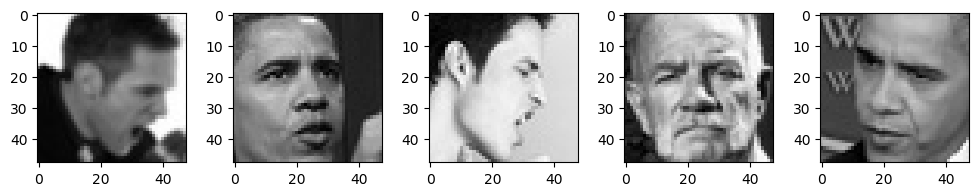

In [18]:
plot_images(train_dir+"/"+"angry")